### Figure
#### Reduced model 

In [ ]:
# Find a clustered basis for neural activity. Cluster hyperplanes, weight each entry in Q by magnitude of hyperplane.


In [1]:
cd /Users/cl1704/PycharmProjects/embedding_dimension/RNN

/Users/cl1704/PycharmProjects/embedding_dimension/RNN


In [2]:
# Imports
from Experiment_1.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns
from Experiment_1.net import *
import os
import numpy as np
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE

matplotlib.rcParams['axes.linewidth'] = .75

2afc


In [141]:
# Load data
df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list, ignore_index=True)
#original_df = original_df[original_df.mse_z < .035]

In [142]:
def compute_var(variance, n):
    return np.sum(variance[n:])

def compute_p(k, null_k):
    return (np.sum(null_k < k) / len(null_k))


In [159]:
df = original_df.copy()

# Restrict to networks with dim and compute variance above dim
dim = 2
df = df[df.dim == dim]
df = df[df.k >= dim]
df['var'] = df.variance.apply(lambda x: compute_var(x, dim))
df['k_inertia'] = df.inertia.apply(lambda x: x[dim - 1])
df['var'] = np.log(df['var'])
df.sort_values('var', ascending=False)

,model_id,w_rec,w_in,w_out,bias,mse_z,weight_decay,threshold,sigma_rec,lambda_std,...,lvar,dim,k,p_value,inertia,activity_std,null_inertia,variance,var,k_inertia
0,FcTeJvgU,"[[0.022260262, 0.00653006, -0.010051201, 0.001...","[[-0.033094015, 0.056794595], [-0.032934062, 0...","[[0.021370161, 0.035784252, 0.16994824, -0.003...","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",0.040116,0.001,0.025,0.0,0.4,...,1.0,2,2,0.0,"[0.6784981109372814, 0.0002583028739083911, 0....",0.034947,"[[0.9982963013554711, 0.9946382707308987, 0.96...","[0.70237833, 0.29743382, 0.00017074423, 9.9679...",-8.579834,0.000258


In [160]:

## Restrict connectivity to PCs
model_data = df[df.model_id == 'FcTeJvgU']
net = Net(n=100, input_size=2, dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.sigma_in = 0.
net.sigma_rec = 0.
u, z, mask, conditions = generate_trials(
    n_trials=25)

# COMPUTE RESPONSES
x = net(u).detach().cpu().numpy()
rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'motion': conditions[k]['motion_coh'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
#df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T
#responses = responses[np.mean(responses, axis=1) >.025, ]
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]

## clustering


w_rec = net.recurrent_layer.weight.data
w_in = net.input_layer.weight.data
w_out = net.output_layer.weight.data
pca = PCA(n_components = 3).fit(responses.T)
U = pca.components_
A = w_rec@U.T
b = net.recurrent_layer.bias.data.detach().cpu().numpy()

A = np.concatenate((A, b[:, None]), axis=1)
# Cluster hyperplanes
k = 2
clustering = KMeans(n_clusters=k, n_init=20).fit(A)

# Compute magnitudes of each hyperplane
magnitudes = np.linalg.norm(A, axis=1)

# Construct Q of shape N x k
q = torch.zeros((A.shape[0], k))
for cluster in range(k):
    for neuron in range(A.shape[0]):
        if np.isin(neuron, np.argwhere(clustering.labels_==cluster)):
            q[neuron, cluster] = torch.tensor(magnitudes[neuron]).float()
q = q/torch.linalg.norm(q,dim=0)

# Construct reduced model
w_rec_reduced = q.t() @ w_rec @ q
w_in_reduced = q.t() @ w_in
w_out_reduced = w_out @ q

# Initialize reduced model
reduced_net = Net(n=k, input_size=2, dale=False)
reduced_net.recurrent_layer.weight.data = w_rec_reduced
reduced_net.recurrent_layer.bias.data = q.t()@torch.tensor(model_data['bias'].item())
reduced_net.input_layer.weight.data = w_in_reduced
reduced_net.output_layer.weight.data = w_out_reduced


reduced_net.sigma_in = 0.
reduced_net.sigma_rec = 0
net.sigma_in = 0.
net.sigma_rec = 0

y = net(u).detach().cpu().numpy()
y_pred =  (reduced_net(u) @ q.t()).detach().numpy()

reduced_net.sigma_in = .03
reduced_net.sigma_rec = 0
net.sigma_in = .03
net.sigma_rec = 0

y_noise = net(u).detach().cpu().numpy()[:,25:,:]
y_pred_noise =  (reduced_net(u) @ q.t()).detach().numpy()[:,25:,:]




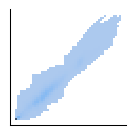

In [162]:
fig = plt.figure(figsize=(1.5, 1.5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

#sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=.1,edgecolor=None)
    

sns.histplot(x = y_noise.flatten(),y = y_pred_noise.flatten(),ax=ax,legend=False,bins=50)
#sns.histplot(x = y.flatten(),y = y_pred.flatten(),ax=ax,legend=False,color='k')

# sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette=palette)

# Model predictions


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("PC 1", fontsize=7)
ax.set_ylabel("PC 2", fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7, bottom=True)
ax.yaxis.set_tick_params(labelsize=7, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('Figures/Figure_reduced.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight', transparent=True)